In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt


import numpy as np
from itertools import combinations
from scipy.stats import ttest_rel, wilcoxon
from scipy import stats
import re
import scikit_posthocs as sp 

from scipy.stats import shapiro, ttest_rel, wilcoxon
import pandas as pd
from itertools import combinations

## Extended Data Figure 2E

In [5]:
CD44 = pd.read_excel('/Users/alackner/Library/CloudStorage/OneDrive-Stanford/Documents/Ongoing-Projects/CITE-seq/manuscript/figures_2025/IF/CD44_Auszaehlungen.xlsx', sheet_name=0)


In [6]:
CD44


,decBAM,decBAM + EVT CM,decPAM,decPAM + EVT CM
0,2974.0,3480.0,228,2582.0
1,4576.0,4463.0,279,1249.0
2,3827.0,2621.0,495,1542.0
3,4670.0,2494.0,179,1806.0
4,3000.0,2701.0,278,1551.0
5,3031.0,3329.0,349,2231.0
6,2478.0,6054.0,320,1281.0
7,2833.0,3432.0,683,1673.0
8,1833.0,1164.0,292,1556.0
9,2285.0,1007.0,253,1474.0


In [ ]:
long = CD44.melt(
    value_vars=['decPAM','decPAM + EVT CM'],
    var_name='condition',
    value_name='value'
).dropna()

sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(3,3))

sns.boxplot(data=long, x='condition', y='value', showfliers=False, ax=ax, width=0.5)
sns.stripplot(data=long, x='condition', y='value', dodge=False, size=7, jitter=0.1,
              alpha=0.7, edgecolor='gray', linewidth=0.5, ax=ax)

ax.set_xlabel('')
ax.set_ylabel('CD44/CD14 colocalization FI count', fontsize=12)
ax.set_title('CD44/CD14 colocalization FI count', fontsize=12, pad=15)
ax.yaxis.set_tick_params(left=True, labelleft=True)
ax.xaxis.set_tick_params(bottom=True, top=False, labelbottom=True, labelsize=12)

plt.tight_layout()

plt.savefig('CD44_IF_stimulation.pdf')
plt.show()



from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu

cond1, cond2 = 'decPAM', 'decPAM + EVT CM'


x = CD44[cond1].dropna().astype(float)
y = CD44[cond2].dropna().astype(float)
n1, n2 = len(x), len(y)

def sh_test(a):
    if 3 <= len(a) <= 5000:
        stat, p = shapiro(a)
        return stat, p, (p > 0.05)
    return None, None, False


sh1, sh1_p, x_normal = sh_test(x)
sh2, sh2_p, y_normal = sh_test(y)

lev_stat, lev_p = (None, None)
eq_var = False
if n1 >= 2 and n2 >= 2:
    lev_stat, lev_p = levene(x, y, center='median')
    eq_var = (lev_p is not None) and (lev_p > 0.05)

if x_normal and y_normal:
    test_name = 'independent_t-test' if eq_var else 'Welch_t-test'
    stat, pval = ttest_ind(x, y, equal_var=eq_var)
else:
    test_name = 'Mann-Whitney_U'
    stat, pval = mannwhitneyu(x, y, alternative='two-sided', method='auto')

results_df = pd.DataFrame([{
    'group_1':          cond1,
    'group_2':          cond2,
    'n_group1':         n1,
    'n_group2':         n2,
    'shapiro_p_x':      sh1_p,
    'shapiro_p_y':      sh2_p,
    'both_normal':      x_normal and y_normal,
    'levene_p':         lev_p,
    'equal_var_assumed': eq_var,
    'test_used':        test_name,
    'test_statistic':   stat,
    'test_pvalue':      pval,
}])

print(results_df)



## Figure 3E

In [ ]:
macros = pd.read_excel('./Macro_Facs_data.xlsx')

In [18]:
macros


,donor_id,sample_id,tissue,actMac,tiMac,inflaMac,trMac
0,1,db-7+1.fcs,decB,0.32,31.70,28.20,30.10
1,2,db-8+1.fcs,decB,0.30,17.90,64.10,10.50
2,3,db-8+6.fcs,decB,0.26,24.90,49.30,13.60
3,4,db-7+1_M.fcs,decB,0.60,28.50,26.40,34.50
4,5,db-7+1.fcs,decB,0.44,17.60,38.00,32.30
5,6,db-9+4.fcs,decB,0.45,25.70,51.80,9.06
6,7,db-7+6.fcs,decB,0.16,34.40,38.00,20.50
7,8,db-8+4.fcs,decB,0.61,14.60,74.30,2.75
8,9,db-6+1.fcs,decB,1.49,7.51,67.30,4.23
9,10,db-7+6.fcs,decB,0.23,10.50,57.30,4.20


In [20]:
macros.dropna(subset=["actMac"], inplace=True)


In [ ]:
for macro in ['tiMac','inflaMac','trMac','actMac']:


    sns.set_theme(style="white")
    palette = sns.color_palette(['#800000','#005f87'], n_colors=macros['tissue'].nunique())


    fig, ax = plt.subplots(figsize=(3, 3))


    sns.boxplot(
        data=macros,
        x='tissue',
        y=macro,
        hue='tissue',
        palette=palette,
        showfliers=False,
        ax=ax,
        width=0.5
    )


    sns.stripplot(
        data=macros,
        x='tissue',
        y=macro,
        hue='tissue',
        palette=palette,
        dodge=False,
        size=7,
        jitter=0.1,
        alpha=0.7,
        edgecolor='gray',
        linewidth=0.5,
        ax=ax
    )


    handles, labels = ax.get_legend_handles_labels()
    n = macros['tissue'].nunique()

    ax.set_xlabel(macro, fontsize=12)
    ax.set_ylabel('Freq of total Mac', fontsize=12)
    ax.set_title(f'Freq {macro} of total Mac', fontsize=12, pad=15)
    ax.yaxis.set_tick_params(left=True, labelleft=True)
    ax.set_ylim(0,100)
    ax.xaxis.set_tick_params(
        which='both',      
        bottom=True,       
        top=False,        
        labelbottom=True,  
        labelsize=12      
    )
    

    
    plt.tight_layout()

    plt.savefig(f'{macro}_new.pdf')
    plt.show()



    wide = macros.pivot(index='donor_id', columns='tissue', values=macro)


    tissues = wide.columns.tolist()
    pairs   = list(combinations(tissues, 2))


    results = []
    for t1, t2 in pairs:
        pair_df = wide[[t1, t2]].dropna()
        x = pair_df[t1]
        y = pair_df[t2]
        n = len(pair_df)

        
        diff = x - y

        
        if n >= 3 and n <= 5000:
            sh_stat, sh_p = shapiro(diff)
            normal = (sh_p > 0.05)
        else:
            sh_stat, sh_p = (None, None)
            normal = False  

        
        if normal:
            test_name = 'paired_t-test'
            stat, pval = ttest_rel(x, y, nan_policy='omit')
        else:
            test_name = 'wilcoxon'
            try:
                stat, pval = wilcoxon(x, y)
            except ValueError:
                stat, pval = (None, None)

        results.append({
            'tissue_1':        t1,
            'tissue_2':        t2,
            'n_pairs':         n,
            'shapiro_p':       sh_p,
            'normal_diff':     normal,
            'test_used':       test_name,
            'test_statistic':  stat,
            'test_pvalue':     pval,
        })

    results_df = pd.DataFrame(results).sort_values('test_pvalue')
    print(results_df)


## Extended Data Figure 4H

In [ ]:
tcell = pd.read_excel('./Tcell_rawdata.xlsx', sheet_name=0)


In [5]:
tcell


,Sample_id,donor_id,tissue,CD4+,CD8+,total
0,NaN,1,decB,0.20894,0.28892,0.49786
1,NaN,1,decP,1.29456,5.10964,6.40420
2,NaN,2,decB,0.80068,0.34780,1.14848
3,NaN,2,decP,2.04572,1.63578,3.68150
4,NaN,3,decB,0.33075,0.27825,0.60900
5,NaN,3,decP,1.51088,1.33456,2.84544
6,NaN,4,decB,0.46500,0.77500,1.24000
7,NaN,4,decP,2.21352,4.98844,7.20196
8,NaN,5,decB,1.21752,2.03490,3.25242
9,NaN,5,decP,3.64640,6.51900,10.16540


In [ ]:
for cell in ['CD4+','CD8+','total']:


    sns.set_theme(style="white")
    palette = sns.color_palette(['#800000','#005f87'], n_colors=tcell['tissue'].nunique())


    fig, ax = plt.subplots(figsize=(3, 3))


    sns.boxplot(
        data=tcell,
        x='tissue',
        y=cell,
        hue='tissue',
        palette=palette,
        showfliers=False,
        ax=ax,
        width=0.5
    )


    sns.stripplot(
        data=tcell,
        x='tissue',
        y=cell,
        hue='tissue',
        palette=palette,
        dodge=False,
        size=7,
        jitter=0.1,
        alpha=0.7,
        edgecolor='gray',
        linewidth=0.5,
        ax=ax
    )


    handles, labels = ax.get_legend_handles_labels()
    n = tcell['tissue'].nunique()



    ax.set_xlabel(cell, fontsize=12)
    ax.set_ylabel('Freq of total CD45+', fontsize=12)
    ax.set_title(f'Freq {cell} of total CD45+', fontsize=12, pad=15)
    ax.yaxis.set_tick_params(left=True, labelleft=True)
    ax.set_ylim(0,15)
    ax.xaxis.set_tick_params(
        which='both',      
        bottom=True,       
        top=False,         
        labelbottom=True,  
        labelsize=12       
    )

    plt.tight_layout()

    plt.savefig(f'{cell}.pdf')
    plt.show()

    wide = tcell.pivot(index='donor_id', columns='tissue', values=cell)

    tissues = wide.columns.tolist()
    pairs   = list(combinations(tissues, 2))

    results = []
    for t1, t2 in pairs:
        pair_df = wide[[t1, t2]].dropna()
        x = pair_df[t1]
        y = pair_df[t2]
        n = len(pair_df)

        diff = x - y

        if n >= 3 and n <= 5000:
            sh_stat, sh_p = shapiro(diff)
            normal = (sh_p > 0.05)
        else:
            sh_stat, sh_p = (None, None)
            normal = False  

        if normal:
            test_name = 'paired_t-test'
            stat, pval = ttest_rel(x, y, nan_policy='omit')
        else:
            test_name = 'wilcoxon'
            try:
                stat, pval = wilcoxon(x, y)
            except ValueError:
                stat, pval = (None, None)

        results.append({
            'tissue_1':        t1,
            'tissue_2':        t2,
            'n_pairs':         n,
            'shapiro_p':       sh_p,
            'normal_diff':     normal,
            'test_used':       test_name,
            'test_statistic':  stat,
            'test_pvalue':     pval,
        })

    results_df = pd.DataFrame(results).sort_values('test_pvalue')
    print(results_df)

## Extended Data Figure 4I

In [ ]:
granzymeB = pd.read_excel('./GranzymeB_ELISA_sum.xlsx')


/var/folders/y1/4n90g3c54dn8vnfp8shymy3m0000gp/T/ipykernel_14919/4056531017.py:23: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


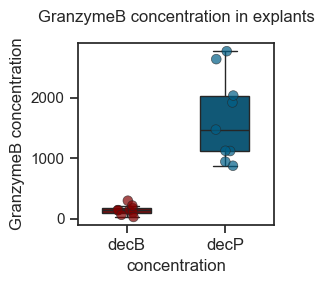

  tissue_1 tissue_2  n_pairs  shapiro_p  normal_diff      test_used  \
0     decB     decP        9   0.213277         True  paired_t-test   

   test_statistic  test_pvalue  
0       -5.928667      0.00035  


In [ ]:
value = 'concentration'  

def plot_granzymeB(granzymeB, value):
    sns.set_theme(style="white")
    n_tissues = granzymeB['tissue'].nunique()
    palette = sns.color_palette(['#800000', '#005f87'], n_colors=n_tissues)

    fig, ax = plt.subplots(figsize=(3, 3))

    sns.boxplot(
        data=granzymeB, x='tissue', y=value, hue='tissue',
        palette=palette, showfliers=False, ax=ax, width=0.5
    )

    sns.stripplot(
        data=granzymeB, x='tissue', y=value, hue='tissue',
        palette=palette, dodge=False, size=7, jitter=0.1,
        alpha=0.7, edgecolor='gray', linewidth=0.5, ax=ax
    )

    ax.set_xlabel(value, fontsize=12) 
    ax.set_ylabel('GranzymeB concentration', fontsize=12)
    ax.set_title('GranzymeB concentration in explants', fontsize=12, pad=15)
    ax.yaxis.set_tick_params(left=True, labelleft=True)
    ax.xaxis.set_tick_params(which='both', bottom=True, top=False, labelbottom=True, labelsize=12)

    plt.tight_layout()
    plt.savefig('elisa_granzymeB.pdf')
    plt.show()


def paired_tests(granzymeB, value):
    wide = granzymeB.pivot(index='donor_id', columns='tissue', values=value)
    results = []

    for t1, t2 in combinations(wide.columns.tolist(), 2):
        pair = wide[[t1, t2]].dropna()
        x, y = pair[t1], pair[t2]
        n = len(pair)

        if 3 <= n <= 5000:
            _, sh_p = shapiro(x - y)
            normal = sh_p > 0.05
        else:
            sh_p, normal = (None, False)

        if normal:
            test_name = 'paired_t-test'
            stat, pval = ttest_rel(x, y, nan_policy='omit')
        else:
            test_name = 'wilcoxon'
            try:
                stat, pval = wilcoxon(x, y)
            except ValueError:
                stat, pval = (None, None)

        results.append({
            'tissue_1': t1,
            'tissue_2': t2,
            'n_pairs': n,
            'shapiro_p': sh_p,
            'normal_diff': normal,
            'test_used': test_name,
            'test_statistic': stat,
            'test_pvalue': pval,
        })

    return pd.DataFrame(results).sort_values('test_pvalue')


plot_granzymeB(granzymeB, value)
results_df = paired_tests(granzymeB, value)
print(results_df)

## Figure 5C

In [ ]:
nk = pd.read_excel('./NK_rawdata.xlsx', sheet_name=0)


In [42]:
nk

,Unnamed: 0,donor_id,tissue,CD16+,CD39+,CD39- CD103+,CD39- CD103-
0,db 10+0,1,db,12.30,53.00,8.55,17.2
1,db 10+5,2,db,8.98,35.20,25.50,25.7
2,dp 10+0,1,dp,1.58,42.40,19.60,34.0
3,dp 10+5,2,dp,2.48,22.10,37.20,35.3
4,db 6+6,3,db,2.10,53.27,4.37,35.5
5,db 7+0,4,db,2.32,52.91,6.56,32.9
6,db 7+5,5,db,5.76,14.82,10.20,65.8
7,db 9+0,6,db,2.56,47.93,2.89,41.8
8,dp 6+6,3,dp,0.90,26.44,12.20,54.9
9,dp 7+0,4,dp,0.75,62.00,7.11,24.6


In [ ]:
for nkcell in ['CD16+','CD39+','CD39- CD103+','CD39- CD103-']:


    sns.set_theme(style="white")
    palette = sns.color_palette(['#800000','#005f87'], n_colors=nk['tissue'].nunique())


    fig, ax = plt.subplots(figsize=(3, 3))


    sns.boxplot(
        data=nk,
        x='tissue',
        y=nkcell,
        hue='tissue',
        palette=palette,
        showfliers=False,
        ax=ax,
        width=0.5
    )


    sns.stripplot(
        data=nk,
        x='tissue',
        y=nkcell,
        hue='tissue',
        palette=palette,
        dodge=False,
        size=7,
        jitter=0.1,
        alpha=0.7,
        edgecolor='gray',
        linewidth=0.5,
        ax=ax
    )


    handles, labels = ax.get_legend_handles_labels()
    n = nk['tissue'].nunique()


    ax.set_xlabel(nkcell, fontsize=12)
    ax.set_ylabel('Freq of total NK', fontsize=12)
    ax.set_title(f'Freq {nkcell} of total NK', fontsize=12, pad=15)
    ax.yaxis.set_tick_params(left=True, labelleft=True)
    ax.set_ylim(0,100)
    ax.xaxis.set_tick_params(
        which='both',      
        bottom=True,       
        top=False,         
        labelbottom=True, 
        labelsize=12       
    )


    plt.tight_layout()

    plt.savefig(f'{nkcell}.pdf')
    plt.show()



    wide = nk.pivot(index='donor_id', columns='tissue', values=nkcell)


    tissues = wide.columns.tolist()
    pairs   = list(combinations(tissues, 2))


    results = []
    for t1, t2 in pairs:
        pair_df = wide[[t1, t2]].dropna()
        x = pair_df[t1]
        y = pair_df[t2]
        n = len(pair_df)


        diff = x - y


        if n >= 3 and n <= 5000:
            sh_stat, sh_p = shapiro(diff)
            normal = (sh_p > 0.05)
        else:
            sh_stat, sh_p = (None, None)
            normal = False  


        if normal:
            test_name = 'paired_t-test'
            stat, pval = ttest_rel(x, y, nan_policy='omit')
        else:
            test_name = 'wilcoxon'
            try:
                stat, pval = wilcoxon(x, y)
            except ValueError:
                stat, pval = (None, None)

        results.append({
            'tissue_1':        t1,
            'tissue_2':        t2,
            'n_pairs':         n,
            'shapiro_p':       sh_p,
            'normal_diff':     normal,
            'test_used':       test_name,
            'test_statistic':  stat,
            'test_pvalue':     pval,
        })

    results_df = pd.DataFrame(results).sort_values('test_pvalue')
    print(results_df)


## Figure 5E

In [ ]:
dc = pd.read_excel('./DC_rawdata.xlsx', sheet_name=0)


In [48]:
dc

,Unnamed: 0,donor_id,tissue,XCR1+,XCR1+ CD1c+,CD1c+,total
0,db 10+0,1,db,0.00744,0.01200,0.68,0.69944
1,db 10+5,2,db,0.03200,0.05700,1.17,1.25900
2,dp 10+0,1,dp,0.34000,0.83000,2.18,3.35000
3,dp 10+5,2,dp,0.09700,0.34000,1.24,1.67700
4,db 6+6,3,db,0.07200,0.10000,0.65,0.82200
5,db 7+0,4,db,0.19000,0.07000,0.45,0.71000
6,db 7+5,5,db,0.01600,0.00739,0.49,0.51339
7,db 9+0,6,db,0.07000,0.04900,0.65,0.76900
8,dp 6+6,3,dp,0.61000,0.74000,0.79,2.14000
9,dp 7+0,4,dp,0.64000,0.35000,0.67,1.66000


In [ ]:

for cell in ['XCR1+','CD1c+','XCR1+ CD1c+']:


    sns.set_theme(style="white")
    palette = sns.color_palette(['#800000','#005f87'], n_colors=dc['tissue'].nunique())


    fig, ax = plt.subplots(figsize=(3, 3))

    sns.boxplot(
        data=dc,
        x='tissue',
        y=cell,
        hue='tissue',
        palette=palette,
        showfliers=False,
        ax=ax,
        width=0.5
    )

    sns.stripplot(
        data=dc,
        x='tissue',
        y=cell,
        hue='tissue',
        palette=palette,
        dodge=False,
        size=7,
        jitter=0.1,
        alpha=0.7,
        edgecolor='gray',
        linewidth=0.5,
        ax=ax
    )

    handles, labels = ax.get_legend_handles_labels()
    n = dc['tissue'].nunique()

    ax.set_xlabel(cell, fontsize=12)
    ax.set_ylabel('Freq of total CD45+', fontsize=12)
    ax.set_title(f'Freq {cell} of total CD45+', fontsize=12, pad=15)
    ax.yaxis.set_tick_params(left=True, labelleft=True)
    ax.set_ylim(0,2.5)
    ax.xaxis.set_tick_params(
        which='both',      
        bottom=True,       
        top=False,         
        labelbottom=True,  
        labelsize=12       
    )

    plt.tight_layout()

    plt.savefig(f'{cell}.pdf')
    plt.show()

    wide = dc.pivot(index='donor_id', columns='tissue', values=cell)

    tissues = wide.columns.tolist()
    pairs   = list(combinations(tissues, 2))

    results = []
    for t1, t2 in pairs:
        pair_df = wide[[t1, t2]].dropna()
        x = pair_df[t1]
        y = pair_df[t2]
        n = len(pair_df)

        diff = x - y

        if n >= 3 and n <= 5000:
            sh_stat, sh_p = shapiro(diff)
            normal = (sh_p > 0.05)
        else:
            sh_stat, sh_p = (None, None)
            normal = False  

        if normal:
            test_name = 'paired_t-test'
            stat, pval = ttest_rel(x, y, nan_policy='omit')
        else:
            test_name = 'wilcoxon'
            try:
                stat, pval = wilcoxon(x, y)
            except ValueError:
                stat, pval = (None, None)

        results.append({
            'tissue_1':        t1,
            'tissue_2':        t2,
            'n_pairs':         n,
            'shapiro_p':       sh_p,
            'normal_diff':     normal,
            'test_used':       test_name,
            'test_statistic':  stat,
            'test_pvalue':     pval,
        })

    results_df = pd.DataFrame(results).sort_values('test_pvalue')
    print(results_df)

## Figure 5G

In [ ]:
pge2 = pd.read_excel('./PGE2_ELISA_sum.xlsx')


In [ ]:
pge2


In [ ]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2", n_colors=pge2['tissue'].nunique())


fig, ax = plt.subplots(figsize=(12, 6))


sns.boxplot(
    data=pge2,
    x='method',
    y='concentration',
    hue='tissue',
    palette=palette,
    showfliers=False,
    ax=ax
)


sns.stripplot(
    data=pge2,
    x='method',
    y='concentration',
    hue='tissue',
    palette=palette,
    dodge=True,
    size=6,
    jitter=0.2,
    alpha=0.7,
    edgecolor='gray',
    linewidth=0.5,
    ax=ax
)


handles, labels = ax.get_legend_handles_labels()
n = pge2['tissue'].nunique()
ax.legend(handles[:n], labels[:n], title='Tissue',
          bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Concentration', fontsize=12)
ax.set_title('Concentration by Method and Tissue', fontsize=14, pad=15)
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')


plt.tight_layout()

plt.savefig('elisa_pge2.pdf')
plt.show()

In [ ]:
desc = (pge2
        .groupby(['method', 'tissue'])['concentration']
        .agg(median='median',
             q1=lambda x: x.quantile(.25),
             q3=lambda x: x.quantile(.75),
             n='count')
        .round(3)                           
        .reset_index())

print("\nMedians and IQRs")
print(desc)


Medians and IQRs
     method tissue  median     q1     q3  n
0   EVT_iso    EVT   5.982  4.558  7.453  5
1   explant   decB   2.832  2.427  4.453  9
2   explant   decP   0.346  0.216  0.512  9
3  isolates   decB   2.692  1.803  2.938  9
4  isolates   decP   0.470  0.436  0.547  7


In [ ]:
def donor_from_sample(s: str) -> str:
    
    return re.sub(r'^(DB|DP|EVT)\s+', '', s).strip()

pge2['donor'] = pge2['sample'].apply(donor_from_sample)


exp = pge2.query("method == 'explant' and tissue in ['decB','decP']")

exp_wide = (exp.pivot_table(index='donor',
                            columns='tissue',
                            values='concentration',
                            aggfunc='mean')
                .dropna())              

w_exp = stats.wilcoxon(exp_wide['decB'], exp_wide['decP'],
                       alternative='greater')

print(f"\nExplants decB vs decP  (paired on {len(exp_wide)} donors)")
print(f"Wilcoxon W = {w_exp.statistic:.0f}, p = {w_exp.pvalue:.4g}")


Explants decB vs decP  (paired on 9 donors)
Wilcoxon W = 45, p = 0.001953


In [24]:
iso_df = pge2.query("method == 'isolates' or tissue == 'EVT'")
groups = [g['concentration'].values
          for _, g in iso_df.groupby('tissue')]

kw_res = stats.kruskal(*groups)
print("\nCell isolates decB vs decP vs EVT")
print(f"Kruskal-Wallis H = {kw_res.statistic:.2f}, p = {kw_res.pvalue:.4g}")

# ---- post-hoc Dunn test with Holm correction ----
dunn = sp.posthoc_dunn(
            iso_df, val_col='concentration',
            group_col='tissue', p_adjust='holm')
print("\nDunn post-hoc (adjusted p-values)\n", dunn.round(4))


Cell isolates decB vs decP vs EVT
Kruskal-Wallis H = 17.10, p = 0.0001936

Dunn post-hoc (adjusted p-values)
          EVT    decB    decP
EVT   1.0000  0.0533  0.0001
decB  0.0533  1.0000  0.0190
decP  0.0001  0.0190  1.0000


## Extended Figure 5B

In [23]:
qPCR = pd.read_excel('/Users/alackner/Library/CloudStorage/OneDrive-Stanford/Documents/Ongoing-Projects/CITE-seq/manuscript/figures_2025/qPCR/qPCR_rawdata.xlsx', sheet_name=0)


In [24]:
qPCR


,Sample_id,donor_id,tissue,PRL,IGFBP1
0,NaN,1,decB,3.163099,3.228561
1,NaN,2,decB,6.549426,11.877913
2,NaN,3,decB,1.119202,3.284404
3,NaN,4,decB,2.284985,12.240141
4,NaN,5,decB,1.829639,14.973275
5,NaN,6,decB,2.750187,13.466105
6,NaN,1,decP,1.622422,0.530212
7,NaN,2,decP,3.785021,4.124857
8,NaN,3,decP,0.613507,0.044468
9,NaN,4,decP,1.172467,1.165882


In [ ]:
for sample in ['PRL','IGFBP1']:

    sns.set_theme(style="white")
    palette = sns.color_palette(['#800000','#005f87'], n_colors=qPCR['tissue'].nunique())

    fig, ax = plt.subplots(figsize=(3, 3))

    sns.boxplot(
        data=qPCR,
        x='tissue',
        y=sample,
        hue='tissue',
        palette=palette,
        showfliers=False,
        ax=ax,
        width=0.5
    )

    sns.stripplot(
        data=qPCR,
        x='tissue',
        y=sample,
        hue='tissue',
        palette=palette,
        dodge=False,
        size=7,
        jitter=0.1,
        alpha=0.7,
        edgecolor='gray',
        linewidth=0.5,
        ax=ax
    )

    handles, labels = ax.get_legend_handles_labels()
    n = qPCR['tissue'].nunique()

    ax.set_xlabel(sample, fontsize=12)
    ax.set_ylabel('Relative mRNA expression', fontsize=12)
    ax.set_title(f'Relative mRNA expression of {sample}', fontsize=12, pad=15)
    ax.yaxis.set_tick_params(left=True, labelleft=True)
    ax.xaxis.set_tick_params(
        which='both',      
        bottom=True,       
        top=False,         
        labelbottom=True,  
        labelsize=12       
    )

    plt.tight_layout()

    plt.savefig(f'{sample}.pdf')
    plt.show()


    wide = qPCR.pivot(index='donor_id', columns='tissue', values=sample)

    tissues = wide.columns.tolist()
    pairs   = list(combinations(tissues, 2))

    results = []
    for t1, t2 in pairs:
        pair_df = wide[[t1, t2]].dropna()
        x = pair_df[t1]
        y = pair_df[t2]
        n = len(pair_df)

        diff = x - y

        if n >= 3 and n <= 5000:
            sh_stat, sh_p = shapiro(diff)
            normal = (sh_p > 0.05)
        else:
            sh_stat, sh_p = (None, None)
            normal = False

        if normal:
            test_name = 'paired_t-test'
            stat, pval = ttest_rel(x, y, nan_policy='omit')
        else:
            test_name = 'wilcoxon'
            try:
                stat, pval = wilcoxon(x, y)
            except ValueError:
                stat, pval = (None, None)

        results.append({
            'tissue_1':        t1,
            'tissue_2':        t2,
            'n_pairs':         n,
            'shapiro_p':       sh_p,
            'normal_diff':     normal,
            'test_used':       test_name,
            'test_statistic':  stat,
            'test_pvalue':     pval,
        })

    results_df = pd.DataFrame(results).sort_values('test_pvalue')
    print(results_df)

## Extended Figure 5E

In [ ]:
CD82 = pd.read_excel('./CD82_rawdata.xlsx', sheet_name=0)


In [21]:
CD82


,Sample_id,donor_id,tissue,CD82
0,NaN,1,decB,5440000
1,NaN,2,decB,4630000
2,NaN,3,decB,1580000
3,NaN,4,decB,2130000
4,NaN,5,decB,788000
5,NaN,6,decB,1000000
6,NaN,7,decB,594000
7,NaN,8,decB,269790
8,NaN,9,decB,1530000
9,NaN,10,decB,1000000


/var/folders/y1/4n90g3c54dn8vnfp8shymy3m0000gp/T/ipykernel_56281/2166557026.py:23: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


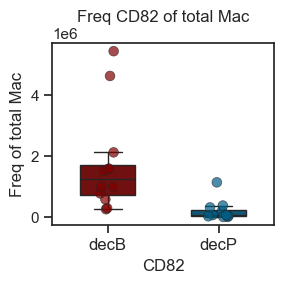

  tissue_1 tissue_2  n_pairs  shapiro_p  normal_diff test_used  \
0     decB     decP       12   0.007995        False  wilcoxon   

   test_statistic  test_pvalue  
0             0.0     0.000488  


In [ ]:
for cell in ['CD82']:

    sns.set_theme(style="white")
    palette = sns.color_palette(['#800000','#005f87'], n_colors=CD82['tissue'].nunique())

    fig, ax = plt.subplots(figsize=(3, 3))


    sns.boxplot(
        data=CD82,
        x='tissue',
        y=cell,
        hue='tissue',
        palette=palette,
        showfliers=False,
        ax=ax,
        width=0.5
    )

    sns.stripplot(
        data=CD82,
        x='tissue',
        y=cell,
        hue='tissue',
        palette=palette,
        dodge=False,
        size=7,
        jitter=0.1,
        alpha=0.7,
        edgecolor='gray',
        linewidth=0.5,
        ax=ax
    )

    handles, labels = ax.get_legend_handles_labels()
    n = CD82['tissue'].nunique()


    ax.set_xlabel(macro, fontsize=12)
    ax.set_ylabel('Freq of total Fib', fontsize=12)
    ax.set_title(f'Freq {cell} of total Fib', fontsize=12, pad=15)
    ax.yaxis.set_tick_params(left=True, labelleft=True)
    #ax.set_ylim(0,15)
    ax.xaxis.set_tick_params(
        which='both',      
        bottom=True,       
        top=False,         
        labelbottom=True,  
        labelsize=12       
    )


    plt.tight_layout()

    plt.savefig(f'{cell}.pdf')
    plt.show()


    wide = CD82.pivot(index='donor_id', columns='tissue', values=cell)


    tissues = wide.columns.tolist()
    pairs   = list(combinations(tissues, 2))

    
    results = []
    for t1, t2 in pairs:
        pair_df = wide[[t1, t2]].dropna()
        x = pair_df[t1]
        y = pair_df[t2]
        n = len(pair_df)


        diff = x - y


        if n >= 3 and n <= 5000:
            sh_stat, sh_p = shapiro(diff)
            normal = (sh_p > 0.05)
        else:
            sh_stat, sh_p = (None, None)
            normal = False  

        if normal:
            test_name = 'paired_t-test'
            stat, pval = ttest_rel(x, y, nan_policy='omit')
        else:
            test_name = 'wilcoxon'

            try:
                stat, pval = wilcoxon(x, y)
            except ValueError:
                stat, pval = (None, None)

        results.append({
            'tissue_1':        t1,
            'tissue_2':        t2,
            'n_pairs':         n,
            'shapiro_p':       sh_p,
            'normal_diff':     normal,
            'test_used':       test_name,
            'test_statistic':  stat,
            'test_pvalue':     pval,
        })

    results_df = pd.DataFrame(results).sort_values('test_pvalue')
    print(results_df)

## Figure 6C

In [9]:
fsc = pd.read_excel('/Users/alackner/Library/CloudStorage/OneDrive-Stanford/Documents/Ongoing-Projects/CITE-seq/manuscript/figures_2025/FACS/Fibroblast_FSC_total.xlsx', sheet_name=0)


In [10]:
fsc


,Sample_id,donor_id,tissue,FSC
0,NaN,1,decB,75726000000
1,NaN,2,decB,142550000000
2,NaN,3,decB,151540000000
3,NaN,4,decB,107820000000
4,NaN,5,decB,49165000000
5,NaN,6,decB,126100000000
6,NaN,7,decB,91491000000
7,NaN,8,decB,111590000000
8,NaN,9,decB,124410000000
9,NaN,10,decB,161420000000


In [ ]:
for cell in ['FSC']:

    sns.set_theme(style="white")
    palette = sns.color_palette(['#800000','#005f87'], n_colors=fsc['tissue'].nunique())

    fig, ax = plt.subplots(figsize=(3, 3))

    sns.boxplot(
        data=fsc,
        x='tissue',
        y=cell,
        hue='tissue',
        palette=palette,
        showfliers=False,
        ax=ax,
        width=0.5
    )

    sns.stripplot(
        data=fsc,
        x='tissue',
        y=cell,
        hue='tissue',
        palette=palette,
        dodge=False,
        size=7,
        jitter=0.1,
        alpha=0.7,
        edgecolor='gray',
        linewidth=0.5,
        ax=ax
    )

    handles, labels = ax.get_legend_handles_labels()
    n = fsc['tissue'].nunique()


    ax.set_xlabel(cell, fontsize=12)
    ax.set_ylabel('FSC-A', fontsize=12)
    ax.set_title(f'{cell}', fontsize=12, pad=15)
    ax.yaxis.set_tick_params(left=True, labelleft=True)

    ax.xaxis.set_tick_params(
        which='both',      
        bottom=True,       
        top=False,         
        labelbottom=True,  
        labelsize=12       
    )


    plt.tight_layout()

    plt.savefig(f'{cell}.pdf')
    plt.show()

    wide = fsc.pivot(index='donor_id', columns='tissue', values=cell)

    tissues = wide.columns.tolist()
    pairs   = list(combinations(tissues, 2))


    results = []
    for t1, t2 in pairs:
        pair_df = wide[[t1, t2]].dropna()
        x = pair_df[t1]
        y = pair_df[t2]
        n = len(pair_df)

        diff = x - y

        if n >= 3 and n <= 5000:
            sh_stat, sh_p = shapiro(diff)
            normal = (sh_p > 0.05)
        else:
            sh_stat, sh_p = (None, None)
            normal = False  

        if normal:
            test_name = 'paired_t-test'
            stat, pval = ttest_rel(x, y, nan_policy='omit')
        else:
            test_name = 'wilcoxon'
            try:
                stat, pval = wilcoxon(x, y)
            except ValueError:
                stat, pval = (None, None)

        results.append({
            'tissue_1':        t1,
            'tissue_2':        t2,
            'n_pairs':         n,
            'shapiro_p':       sh_p,
            'normal_diff':     normal,
            'test_used':       test_name,
            'test_statistic':  stat,
            'test_pvalue':     pval,
        })

    results_df = pd.DataFrame(results).sort_values('test_pvalue')
    print(results_df)

## Figure 6E

In [ ]:
cortisol = pd.read_excel('./Cortisol_ELISA_sum.xlsx')


In [ ]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2", n_colors=cortisol['tissue'].nunique())


fig, ax = plt.subplots(figsize=(12, 6))


sns.boxplot(
    data=cortisol,
    x='method',
    y='concentration',
    hue='tissue',
    palette=palette,
    showfliers=False,
    ax=ax
)

sns.stripplot(
    data=cortisol,
    x='method',
    y='concentration',
    hue='tissue',
    palette=palette,
    dodge=True,
    size=6,
    jitter=0.2,
    alpha=0.7,
    edgecolor='gray',
    linewidth=0.5,
    ax=ax
)


handles, labels = ax.get_legend_handles_labels()
n = cortisol['tissue'].nunique()
ax.legend(handles[:n], labels[:n], title='Tissue',
          bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Concentration', fontsize=12)
ax.set_title('Concentration by Method and Tissue', fontsize=14, pad=15)
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')


plt.tight_layout()

plt.savefig('elisa_cortisol.pdf')
plt.show()

In [ ]:
desc = (cortisol
        .groupby(['method', 'tissue'])['concentration']
        .agg(median='median',
             q1=lambda x: x.quantile(.25),
             q3=lambda x: x.quantile(.75),
             n='count')
        .round(3)                           
        .reset_index())

print("\nMedians and IQRs")
print(desc)
def donor_from_sample(s: str) -> str:
    
    return re.sub(r'^(DB|DP|EVT)\s+', '', s).strip()

cortisol['donor'] = cortisol['sample'].apply(donor_from_sample)


exp = cortisol.query("method == 'explant' and tissue in ['decB','decP']")

exp_wide = (exp.pivot_table(index='donor',
                            columns='tissue',
                            values='concentration',
                            aggfunc='mean')
                .dropna())              

w_exp = stats.wilcoxon(exp_wide['decB'], exp_wide['decP'],
                       alternative='greater')

print(f"\nExplants decB vs decP  (paired on {len(exp_wide)} donors)")
print(f"Wilcoxon W = {w_exp.statistic:.0f}, p = {w_exp.pvalue:.4g}")



iso_df = cortisol.query("method == 'isolates' or tissue == 'EVT'")
groups = [g['concentration'].values
          for _, g in iso_df.groupby('tissue')]

kw_res = stats.kruskal(*groups)
print("\nCell isolates decB vs decP vs EVT")
print(f"Kruskal-Wallis H = {kw_res.statistic:.2f}, p = {kw_res.pvalue:.4g}")


dunn = sp.posthoc_dunn(
            iso_df, val_col='concentration',
            group_col='tissue', p_adjust='holm')
print("\nDunn post-hoc (adjusted p-values)\n", dunn.round(4))


Medians and IQRs
     method tissue  median     q1     q3  n
0       EVT    EVT   0.296  0.184  0.314  5
1   explant   decB   1.043  0.565  1.978  9
2   explant   decP   0.364  0.176  0.448  9
3  isolates   decB   0.130  0.116  0.177  3
4  isolates   decP   0.145  0.117  0.170  3

Explants decB vs decP  (paired on 9 donors)
Wilcoxon W = 45, p = 0.001953

Cell isolates decB vs decP vs EVT
Kruskal-Wallis H = 4.05, p = 0.1321

Dunn post-hoc (adjusted p-values)
          EVT    decB    decP
EVT   1.0000  0.2487  0.2487
decB  0.2487  1.0000  0.9020
decP  0.2487  0.9020  1.0000
